# OTHER MACHINE LEARNING TECHNIQUES

**CONTENTS**

[1. Outliers](#outliers)

[2. Feature scaling](#feature_scaling)

[3. Feature selection](#feature_selection)

[4. Multicolinearity](#multicolinearity)

[5. PCA](#pca)

[6. Feature Engineering](#feature_engineering)


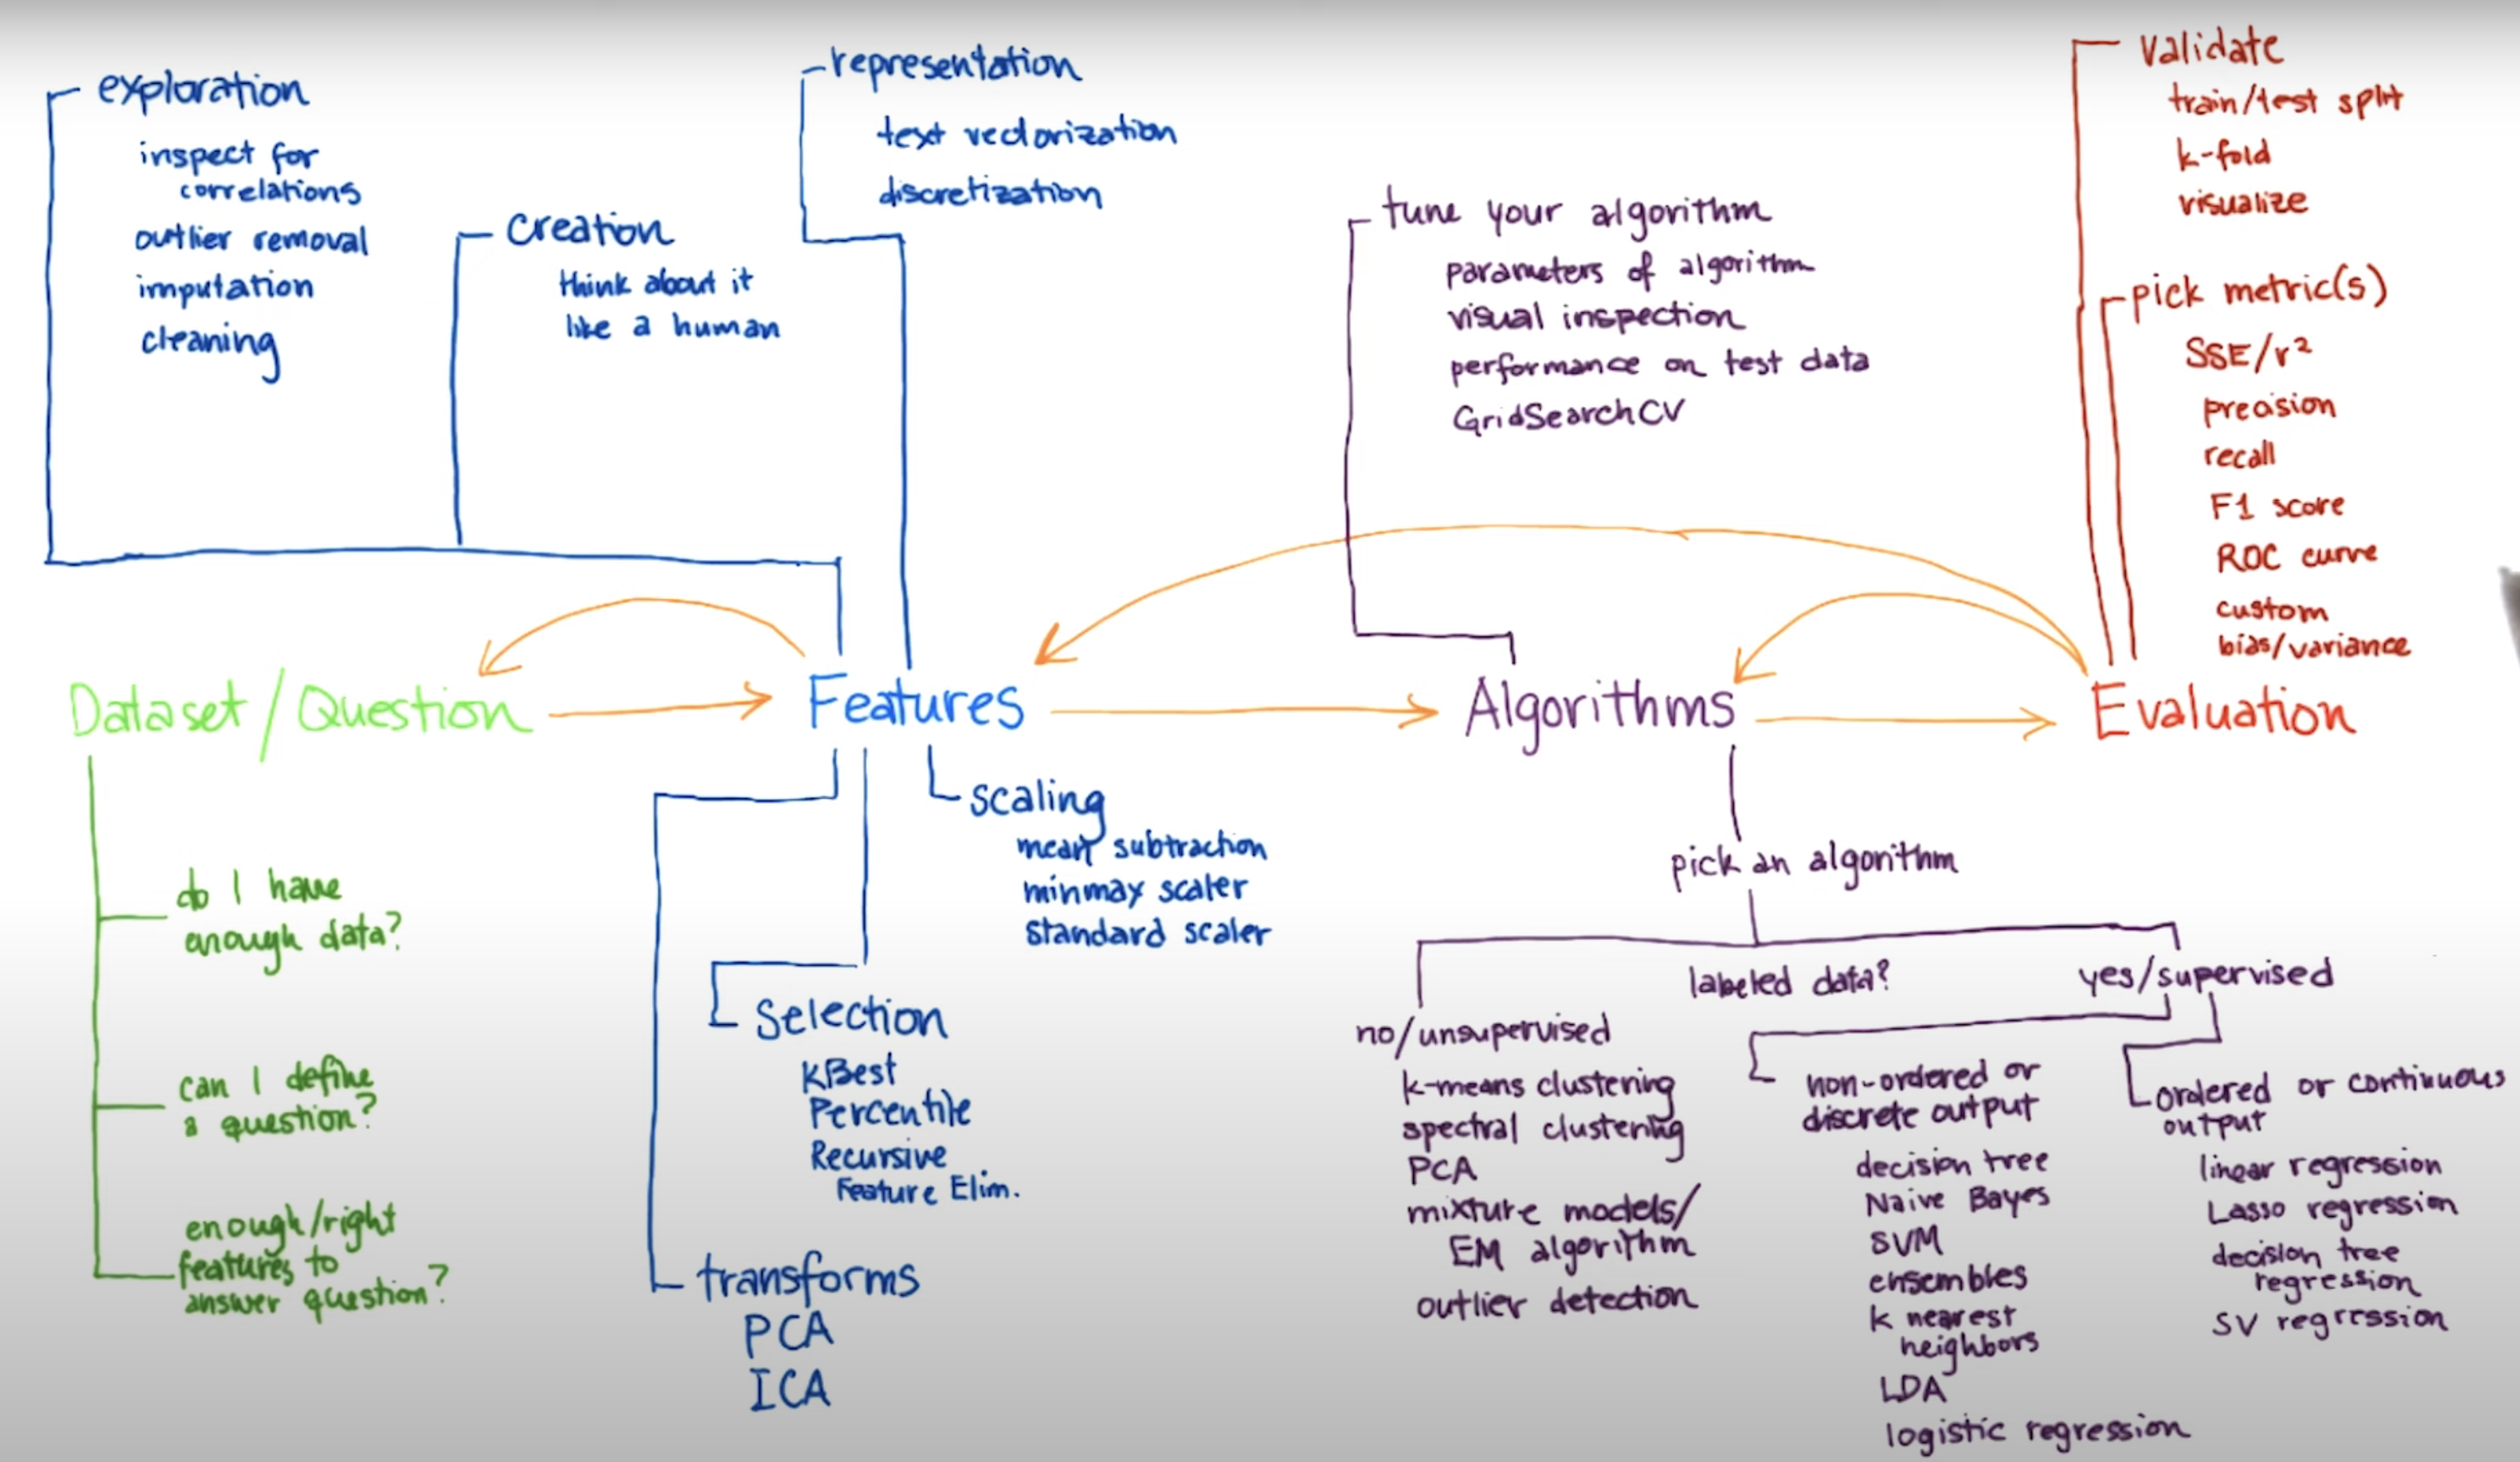

In [298]:
from IPython.display import Image
Image("img/udacity_ML_contents.png")

<a id='outliers'></a>
## 1. OUTLIERS

### TYPE OF OUTLIERS

- Outliers can be caused by sensor malfunction, data entry errors; which should be removed.
- Outliers from freak event => must be paid attention to and should not be omitted from the data.

### OUTLIER REMOVAL STRATEGY

- Including 3 steps: 
    + Step 1: train the data
    + Step 2: remove points with largest residual error (|real_val - predicted_val|)(~ 10% out the data points)
    + Step 3: re-train again and compare the r2 score of the train set.

**CASE STUDY DESCRIPTION**
- Predict net_worth according to age.
- Input file: 2 pickle files: "data/practice_outliers_ages.pkl" for age and "data/practice_outliers_net_worths.pkl" for net_worth.

**LOAD THE DATA**

In [299]:
### import neccessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [300]:
### Load and transform data
ages = pickle.load( open("data/practice_outliers_ages.pkl", "rb") )
net_worths = pickle.load( open("data/practice_outliers_net_worths.pkl", "rb") )

In [301]:
ages = np.reshape(np.array(ages),(len(ages), 1))
net_worths = np.reshape(np.array(net_worths), (len(net_worths), 1))
ages_train, ages_test, net_worths_train, net_worths_test = train_test_split(ages, net_worths, 
                                                                test_size = 0.1, random_state = 42)
print("Train:", len(ages_train))
print("Test:", len(ages_test))

Train: 90
Test: 10


**FUNCTIONS TO FIT, PLOT AND CLEAN DATA**

In [302]:
def fitData(ages_train, net_worths_train, ages_test, net_worths_test):
    """ Fit linear regression
        print out the slope, intercept and r2 score
        return the reg model"""
    reg = LinearRegression()
    reg.fit(ages_train, net_worths_train)
    print("Slope:", reg.coef_)
    print("Intercept:", reg.intercept_)
    print("r2 score, train data:", reg.score(ages_train, net_worths_train))
    print("r2 score, test data:", reg.score(ages_test, net_worths_test))
    return reg

def plotData(ages_train, net_worths_train, ages_test, net_worths_test, reg):
    """Plot the data (train/test) as scatter plot and plot the regression line"""
    plt.scatter(ages_train, net_worths_train, color = "blue", alpha = 0.5)
    plt.scatter(ages_test, net_worths_test, color = "green", alpha = 0.5)
    plt.plot(ages, reg.predict(ages))
    plt.xlabel("ages")
    plt.ylabel('net_worth')

def outlierCleaner(ages_train, net_worths_train, reg):
    """ Remove 10% of the train data with the largest residual errors 
        (difference between the prediction and the actual net worth)
        Return the new trainning data
    """
    cleaned_data = []
    preds = reg.predict(ages_train)
    for i in range(len(preds)):
        error = abs(preds.item(i) - net_worths_train.item(i))
        cleaned_data.append([ages_train.item(i), net_worths_train.item(i), error])
    ### sort the cleaned_data according to the residual error
    cleaned_data.sort(key = lambda x: x[2])
    cleaned_data = cleaned_data[:len(ages_train) - int(len(ages_train)/10)]
    ages, net_worths, _ = zip(*cleaned_data)
    ages = np.reshape(np.array(ages), (len(ages),1))
    net_worths = np.reshape(np.array(net_worths), (len(net_worths),1))
    
    return ages, net_worths

### OUTLIER REMOVAL PROCESS

Slope: [[5.07793064]]
Intercept: [25.21002155]
r2 score, train data: 0.4898725961751499
r2 score, test data: 0.8782624703664675


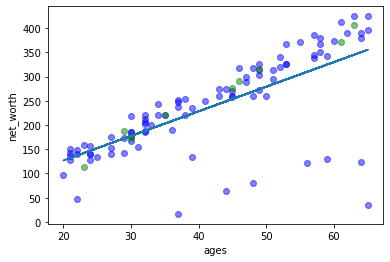

In [303]:
### Step 1: train the data
reg = fitData(ages_train, net_worths_train, ages_test, net_worths_test)
plotData(ages_train, net_worths_train, ages_test, net_worths_test, reg)

In [304]:
### Step 2: remove points with largest residual error (|real_val - predicted_val|)(~ 10% out the data points)
new_ages_train, new_net_worths_train = outlierCleaner(ages_train, net_worths_train, reg)
print(len(new_ages_train), len(new_net_worths_train))

81 81


Slope: [[6.36859481]]
Intercept: [-6.91861069]
r2 score, train data: 0.9513734907601892
r2 score, test data: 0.983189455395532


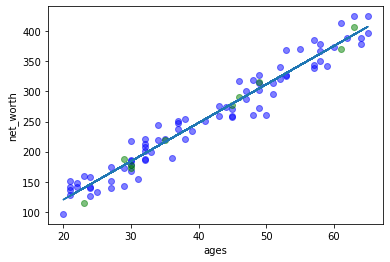

In [305]:
### Step 3: re-train again and compare the r2 score of the train set.
reg = fitData(new_ages_train, new_net_worths_train, ages_test, net_worths_test)
plotData(new_ages_train, new_net_worths_train, ages_test, net_worths_test, reg)

<a id = 'feature_scaling'></a>
## 2. FEATURE SCALING

### WHICH ALGORITHMS NEED FEATURE SCALING

- Algorithms in which 2 dimensions affact the outcome will be affected by rescaling, such as:
    + SVM with rbf kernel
    + k-means clustering
- Algorithms that don't need rescaling:
    + In linear regression, the coefficient and the feature always go together => no need to rescaling.
    + Decision Trees use vertical and horizontal lines so there is no trade off. 


In [306]:
from sklearn.preprocessing import MinMaxScaler

In [307]:
## example feature_1:
feature_1 = np.array([115., 140., 175.])
feature_1 = np.reshape(feature_1, (len(feature_1), 1))
scaler = MinMaxScaler()
rescaled_feature_1 = scaler.fit_transform(feature_1)
rescaled_feature_1

array([[0.        ],
       [0.41666667],
       [1.        ]])

<a id = 'feature_selection'></a>
## 3. FEATURE SELECTION

### WHEN TO GET RID OF FEATURE

- It's noisy
- It causes overfitting
- It is strongly related (highly correlated) with a feature that's already present => See **Part 3** for checking multicollinearity.
- Additional feature slow down training/testing process

### 3.1. FEATURE SELECTION USING CLASSIFIER:
- Feature importance can be access through the model using the attribute `feature_importances_`:

    `clf.feature_importances_`

In [308]:
### Load and process the data
import random
with open ("data/college_admission.txt") as f:
    X, y, count = [], [], 0
    while f.readline():
        x = f.readline()
        try:
            x1, x2, yi = x.split("\n")[0].split(",")
            ### generate a random feature x3 which is either 0 or 1 to check for its feature importance
            x3 = random.randint(0, 1)
            
            X.append([float(x1), float(x2), x3])
            y.append(int(yi))
            count += 1
        except:
            print("Parsing error. Line: ", count)
    print(len(X), len(y))

## split train/test set
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print(len(X_train), len(X_test), len(y_train), len(y_test))

50 50
40 10 40 10


In [309]:
#### Fit and predict the data with Decision Tree
from sklearn import tree
from sklearn.metrics import accuracy_score
## initialize the classifier
clf = tree.DecisionTreeClassifier()
## fit the data
clf = clf.fit(X_train, y_train)
#predict the data
y_pred = clf.predict(X_test)
print("Accuracy score of the prediction", accuracy_score(y_test, y_pred))

Accuracy score of the prediction 0.9


In [310]:
### Get a list of the relative importance of all the features being used using the attribute feature_importances_
clf.feature_importances_

array([0.55754476, 0.44245524, 0.        ])

**=> Both 2 features 1 and 2 are important for the prediction, but not feature 3 which has importance value = 0.**

In [311]:
sel_ = SelectFromModel(linear_model.LogisticRegression(C = 1, penalty = 'l1'))
scaler = StandardScaler()
scaler.fit(X_train)
sel_.fit(scaler.transform(X_train), y_train)

/opt/anaconda3/envs/data_analysis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


SelectFromModel(estimator=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
        max_features=None, norm_order=1, prefit=False, threshold=None)

In [312]:
sel_.get_support()
# So True is for the features that lasso thought is important (non-zero features) 
# while False is for the features whose weights were shrinked to zero 
# and are not important according to Lasso.

array([ True,  True,  True])

In [313]:
selected_feat = ["feature 1", "feature 2", "feature 3"]
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
      np.sum(np.sum(sel_.estimator_.coef_,axis = 0) == 0)))

total features: 3
selected features: 3
features with coefficients shrank to zero: 0


### 3.2. FEATURE SELECTION USING REGULARIZATION:

- [Ref](https://towardsdatascience.com/feature-selection-using-regularisation-a3678b71e499)
- **Regularlization**: adding a penalty to the different parameters of the ML model to reduce the freedom of the model => avoid overfitting. In linear model regularization, the penalty is applied over the coefficients.
- Type of regularization: 
        + Lasso (L1): shrink some of the coefficients to zero.
        + Ridge (L2 regularization) does not shrink coefficients to zero.

#### Using the Lasso regularization classification problem to select features 

**CASE STUDY EXAMPLE:**

- A part of the [The BNP Paribas Cardif Claims Management dataset](https://www.kaggle.com/c/bnp-paribas-cardif-claims-management)

In [314]:
### import necessary packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

In [315]:
data = pd.read_csv("data/paribas_claims.csv", nrows = 50000)
print(data.shape)
data.head(3)

(50000, 133)


,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472


In [316]:
#### Select the numeric variables only
numerics = ['int16','int32','int64','float16','float32','float64']
numerical_vars = list(data.select_dtypes(include = numerics).columns)
data = data[numerical_vars]
data.shape

(50000, 114)

In [317]:
X_train, X_test, y_train, y_test = train_test_split(
                data.drop(labels=['target', 'ID'], axis=1),
                data['target'], test_size=0.3, random_state=0)
X_train.shape, X_test.shape

((35000, 112), (15000, 112))

In [318]:
# Scaling the data, as linear models benefits from feature scaling
scaler = StandardScaler()
scaler.fit(X_train.fillna(0))
sel_ = SelectFromModel(LogisticRegression(C = 1, penalty = 'l1'))
sel_.fit(scaler.transform(X_train.fillna(0)), y_train)

/opt/anaconda3/envs/data_analysis/lib/python3.7/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/anaconda3/envs/data_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """
/opt/anaconda3/envs/data_analysis/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


SelectFromModel(estimator=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
        max_features=None, norm_order=1, prefit=False, threshold=None)

In [319]:
sel_.get_support()
selected_feat = X_train.columns[(sel_.get_support())]
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
      np.sum(sel_.estimator_.coef_ == 0)))

total features: 112
selected features: 79
features with coefficients shrank to zero: 33


In [320]:
removed_feats = X_train.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
removed_feats

Index(['v11', 'v20', 'v29', 'v33', 'v37', 'v41', 'v42', 'v48', 'v49', 'v53',
       'v55', 'v62', 'v63', 'v64', 'v65', 'v67', 'v68', 'v81', 'v86', 'v87',
       'v88', 'v94', 'v95', 'v96', 'v97', 'v103', 'v104', 'v106', 'v115',
       'v121', 'v122', 'v126', 'v131'],
      dtype='object')

In [321]:
X_train_selected = sel_.transform(X_train.fillna(0))
X_test_selected = sel_.transform(X_test.fillna(0))
X_train_selected.shape, X_test_selected.shape

((35000, 79), (15000, 79))

In [322]:
def linearRegression(X_train, y_train, X_test, y_test):
    scaler = StandardScaler()
    ### Create linear regression object
    regr = linear_model.LinearRegression()
    # Train the model using the train set
    regr.fit(X_train.fillna(0), y_train)
    y_test_pred = regr.predict(X_test.fillna(0))
    ### Compare MSE between training and testing
    print("The mean square error of training data: %.2f"%mean_squared_error(y_train, regr.predict(X_train.fillna(0))))
    print("The mean square error of testing data: %.2f"%mean_squared_error(y_test, y_test_pred))

In [323]:
linearRegression(X_train, y_train, X_test, y_test)

The mean square error of training data: 0.17
The mean square error of testing data: 0.17


In [324]:
def linearRegression(X_train, y_train, X_test, y_test):
    scaler = StandardScaler()
    ### Create linear regression object
    regr = linear_model.LinearRegression()
    # Train the model using the train set
    regr.fit(X_train, y_train)
    y_test_pred = regr.predict(X_test)
    ### Compare MSE between training and testing
    print("The mean square error of training data: %.2f"%mean_squared_error(y_train, regr.predict(X_train)))
    print("The mean square error of testing data: %.2f"%mean_squared_error(y_test, y_test_pred))
linearRegression(X_train_selected, y_train, X_test_selected, y_test)

The mean square error of training data: 0.17
The mean square error of testing data: 0.17


<a id='multicolinearity'></a>
## 4. MULTICOLLINEARITY

- [Good reference](https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/)
- 2 or more independent variables are highly correlated with one another in a regression model.
- Examples: BMI and weight, height are multicollinearity since BMI is created from weight and height; temperature in oF and oC; "Dummy variable trap": need only 1 variable with 2 values 0/1 for married and single, but instead, use 2 dummy variables for both married and single status.
- Problem when has multicollinearity:
    + Difficult to distinguish the effect of each feature on the outcome => affect the interpretation of a ML model (understand why the prediction works, why a classifier choose a particular class => drive the business strategy). 
    
#### Methods to detect multicollinearity:

- Correlation matrix and scatter plots => show the bivariate relationship between the independent variables. 
- VIF is preferred as it can show the correlation of a variable with a group of other variables.

### 4.1. DETECTING MULTICOLLINEARITY USING VARIABLE INFLATION FACTORS (VIF)

- VIF determines the strength of the correlation between the independent variables. 
- It is predicted by taking a variable and regressing it against every other variable.
- R square score is used to calculate the VIF value. R2 score is closer to 1 => the higher the multicollinearity is.

    VIF = 1/(1-R2)
    
   + VIF == 1: no correlation between the feature with other features
   + VIF > 5 or 10 (depends): high multicollinearity betwwen the feature with other features.

In [325]:
### import VIF from statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [326]:
def calculateVIF(df):
    """
    Calculate the VIF for each feature in the dataframe df using the VIF from statsmodels package
    Return the VIF value (as a dataframe) for each feature in the dataframe 
    """
    vif = pd.DataFrame()
    vif['features'] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    
    return vif

In [327]:
### Load the example data to check the multicollinearity among variables
salary_df = pd.read_csv("data/salary.csv")
print(salary_df.shape)
salary_df.head(3)

(24, 5)


,Gender,Age,Years of service,Education level,Salary
0,0,27,1.7,0,39343
1,1,26,1.1,1,43205
2,1,26,1.2,0,47731


In [328]:
calculateVIF(salary_df.iloc[:,:-1])

,features,VIF
0,Gender,2.207155
1,Age,13.706320
2,Years of service,10.299486
3,Education level,2.409263


**=> the ‘Age’ and ‘Years of service’ have a high VIF value, meaning they can be predicted by other independent variables in the dataset.**

### 4.2. FIXING MULTICOLLINEARITY

- **WHEN NEED TO FIX MULTICOLLINEARITY:**
    + When need to know the impact of each feature on the outcome. If multicollinearity is not present in the features you are interested in, then multicollinearity may not be a problem.
    + When need to reduce number of features.
- Dropping variables should be an iterative process starting with the variable having the **largest VIF** value because its trend is highly captured by other variables. 
- Note: After fixing, the VIF values for other variables would have reduced too, although to a varying extent.

In [329]:
### Example: combining "Age" and "Years of service" features
salary_df_reduced = salary_df.copy()
salary_df_reduced['Age_YearService'] = salary_df_reduced.apply(lambda x: x['Age']\
                                        - x['Years of service'], axis = 1)
salary_df_reduced = salary_df_reduced.drop(['Age', 'Years of service'], axis = 1)
salary_df_reduced.head(3)

,Gender,Education level,Salary,Age_YearService
0,0,0,39343,25.3
1,1,1,43205,24.9
2,1,0,47731,24.8


In [330]:
calculateVIF(salary_df_reduced.iloc[:,:-1])

,features,VIF
0,Gender,2.333204
1,Education level,2.507384
2,Salary,3.756664


<a id='pca'></a>
## 5. PRINCIPAL COMPONENT ANALYSIS (PCA)

### 5.1. WHAT IS PCA

Given a set of data points, PCA 
    + finds a new coordinate system that obtained from the old one by translation and rotation only.
    + moves the center of the coordinate system to the center of the data.
    + moves the x axis into the principle axis of variation (where the most variation is)
    + moves the other axes into the orthogonal less important direction of variation.

- Principal component of a dataset is the direction that has the largest variance that retains maximum amount of information in original data.

### 5.2. WHEN TO USE PCA

- Identify the latent features driving the pattern in the data
- Dimensionality reduction: 
    + help to visualize high-dimensional data
    + reduce noise
    + make the ML algorithms (regression, classification) work better with fewer features. For example: PCA for Facial recognition (eigenfaces dataset).

**WHY PCA IS GOOD FOR FACIAL RECOGNITION**

- Pictures of faces generally have high input dimensionality (may pixels).
- Faces have general patterns that could be captured in smaller number of dimensions.

### 5.3. EXAMPLE FOR ML PROCESS USING PCA FOLLOWED BY SVM

- STEP 1: Prepare the data - Split data into train/test set
- STEP 2: PCA fit the train set, PCA transform the train set
- STEP 3: SVC fit on the train set
- STEP 4: PCA transform on the test set
- STEP 5: SVC predict on the test set

### 5.4. HOW MANY PCs TO USE?

- Train on different number of PCs, and see how accuracy responds.
- Use the cut-off value where adding more PCs doesn't get much more discrimination.

### 5.5. CASE STUDY: EIGENFACES

In [331]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people

#### STEP 1: Prepare the data - Split data into train/test set

In [332]:
### Loading the eigenfaces data
lfw_people = fetch_lfw_people(min_faces_per_person = 70, resize = 0.4)

In [333]:
### Process the eigenfaces data
X, y = lfw_people.data, lfw_people.target
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
X_train.shape, X_test.shape

((966, 1850), (322, 1850))

In [355]:
### Meta data of the eigenfaces data
n_samples, h, w = lfw_people.images.shape
n_features = X.shape[1]
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
print(n_samples, n_features, n_classes)

1288 1850 7


**=> The number of features is more larger than the number of sample => Need to reduce the data** 

#### STEP 2: PCA fit the train set - PCA transform the train set

In [356]:
### Performing PCA unsupervised feature extraction/dimensionality reduction
from sklearn.decomposition import PCA as RandomizedPCA
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

n_components = 150 # optimized value
### Explore the good n_components value:
#n_component_list = [10, 15, 25, 50, 100, 150, 250]

print("Extracting the top {} eigenfaces from {} faces".format(n_components, X_train.shape[0]))
start_time = time()
pca = RandomizedPCA(n_components = n_components, whiten = True)
pca.fit(X_train)
print("... done in {0:.3f}s".format(time() - start_time))

Extracting the top 150 eigenfaces from 966 faces
... done in 0.078s


In [357]:
#### Explore the PCA
print(pca.components_.shape)
print("PCA first component:", pca.components_[0])
print("PCA second component:", pca.components_[1])
### the first PC giving the direction of maximal variance, 
# second PC has second-largest variance
print("How much of the variance is explained by the 1st principal component:", pca.explained_variance_[0])
print("How much of the variance is explained by the 2nd principal component:", pca.explained_variance_[1])

(150, 1850)
PCA first component: [-0.00685209 -0.00752694 -0.00918908 ... -0.01433786 -0.0129419
 -0.01188292]
PCA second component: [ 0.02304094  0.0215521   0.02275391 ... -0.0440019  -0.04318584
 -0.04226126]
How much of the variance is explained by the 1st principal component: 501417.97
How much of the variance is explained by the 2nd principal component: 391794.8


In [358]:
### PCA transform the train set
print("Projecting the input data on the eigenfaces orthonormal basis")
start_time = time()
X_train_pca = pca.transform(X_train)
print("... done in {0:.3f}s".format(time() - start_time))

Projecting the input data on the eigenfaces orthonormal basis
... done in 0.008s


#### STEP 3: SVC fit on the train set

In [359]:
### Train a SVM classification model
print("Fitting the classifier to the training set")
params = {'C':[1e3, 5e3, 1e4, 5e4, 1e5]} 
          #'gamma': ['auto', 'scale'], 
          #'kernel':['linear', 'rbf']}
start_time = time()
X_train_pca = pca.transform(X_train)
clf = GridSearchCV(SVC(class_weight = 'balanced', kernel = 'rbf', gamma = 'scale'), params, cv = 5)
clf.fit(X_train_pca, y_train)
print("... done in {0:.3f}s".format(time() - start_time))
print("Best estimator found by grid search:", clf.best_estimator_)

Fitting the classifier to the training set
... done in 9.892s
Best estimator found by grid search: SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


#### STEP 4: PCA transform on the test set

In [360]:
### transform on the test set
X_test_pca = pca.transform(X_test)

#### STEP 5: SVC predict on the test set

In [361]:
print("Predicting the people names on the testing set")
start_time = time()
y_pred = clf.predict(X_test_pca)
print("... done in {0:.3f}s".format(time() - start_time))


Predicting the people names on the testing set
... done in 0.065s


In [362]:
y_pred

array([3, 3, 6, 3, 3, 3, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 1, 3,
       3, 3, 3, 1, 1, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 1,
       1, 1, 4, 3, 3, 3, 3, 3, 0, 3, 6, 2, 3, 3, 5, 3, 1, 1, 3, 4, 3, 3,
       6, 4, 1, 3, 1, 6, 3, 3, 3, 2, 1, 6, 3, 4, 3, 0, 4, 3, 3, 3, 3, 3,
       3, 3, 3, 6, 3, 1, 1, 3, 1, 1, 6, 6, 3, 1, 3, 1, 3, 1, 3, 3, 3, 1,
       4, 1, 3, 3, 3, 1, 3, 4, 1, 3, 1, 3, 3, 0, 3, 4, 4, 3, 1, 3, 6, 6,
       6, 3, 2, 4, 3, 3, 1, 6, 2, 2, 5, 1, 3, 3, 1, 3, 3, 1, 1, 1, 1, 3,
       3, 3, 6, 3, 1, 3, 6, 5, 5, 1, 3, 1, 5, 1, 3, 3, 1, 1, 3, 1, 5, 6,
       3, 2, 2, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 2, 3, 2, 3, 3, 6, 3, 3, 6,
       3, 6, 3, 2, 1, 2, 3, 1, 6, 2, 3, 1, 3, 4, 3, 3, 3, 3, 3, 3, 3, 1,
       3, 3, 3, 1, 6, 3, 3, 3, 1, 3, 3, 3, 1, 0, 3, 1, 6, 3, 3, 3, 3, 4,
       2, 3, 3, 0, 3, 3, 3, 3, 4, 3, 3, 1, 3, 4, 3, 1, 6, 3, 3, 3, 2, 1,
       3, 3, 3, 1, 3, 6, 1, 1, 3, 3, 6, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 0,
       3, 3, 3, 4, 3, 3, 5, 3, 3, 1, 4, 3, 3, 4, 3,

#### STEP 6: Validation

In [363]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [364]:
print(classification_report(y_test, y_pred, target_names = target_names))
print(confusion_matrix(y_test, y_pred, labels = range(n_classes)))

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.46      0.63        13
     Colin Powell       0.81      0.87      0.84        60
  Donald Rumsfeld       0.94      0.59      0.73        27
    George W Bush       0.78      0.98      0.87       146
Gerhard Schroeder       0.95      0.72      0.82        25
      Hugo Chavez       1.00      0.47      0.64        15
       Tony Blair       1.00      0.72      0.84        36

        micro avg       0.83      0.83      0.83       322
        macro avg       0.93      0.69      0.77       322
     weighted avg       0.86      0.83      0.82       322

[[  6   2   0   5   0   0   0]
 [  0  52   0   8   0   0   0]
 [  0   2  16   9   0   0   0]
 [  0   3   0 143   0   0   0]
 [  0   1   0   6  18   0   0]
 [  0   3   0   4   1   7   0]
 [  0   1   1   8   0   0  26]]


**Visualization of the prediction result using pylab**

In [365]:
import pylab as pl

In [366]:
target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')

In [367]:
def title(y_pred, y_test, target_names, i):
    """Make label for each image from target_names
    Each label would be as followed: 
        Predicted: LastName
        True     : LastName
    
    """
    pred_name = target_names[y_pred[i]].split(' ')[-1] # get only the last name from label
    true_name = target_names[y_test[i]].split(' ')[-1]
    return 'Predicted: {}\nTrue      : {}'.format(pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]
prediction_titles[:2]

['Predicted: Bush\nTrue      : Bush', 'Predicted: Bush\nTrue      : Bush']

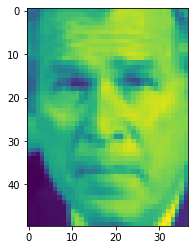

In [368]:
pl.imshow(X_test[0].reshape((h, w)))
pl.show()

In [369]:
def plot_image(images, titles, h, w, n_row = 3, n_col = 4):
    """Plot the images
    """
    pl.figure(figsize = (1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom = 0, left = .01, right = .99, top = .90, hspace = .35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap = pl.cm.gray)
        pl.title(titles[i], size = 12)
        pl.xticks(())
        pl.yticks(())

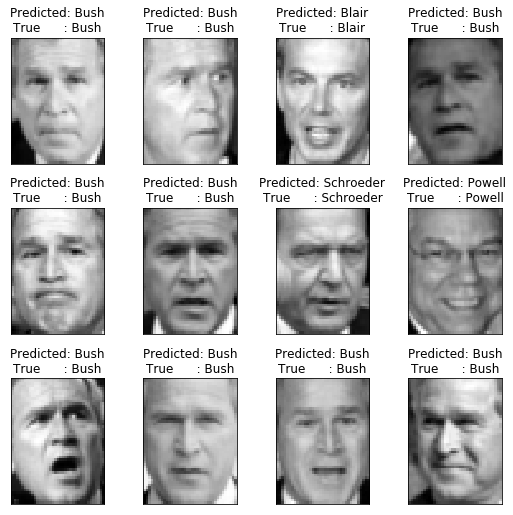

In [370]:
plot_image(X_test, prediction_titles, h, w)

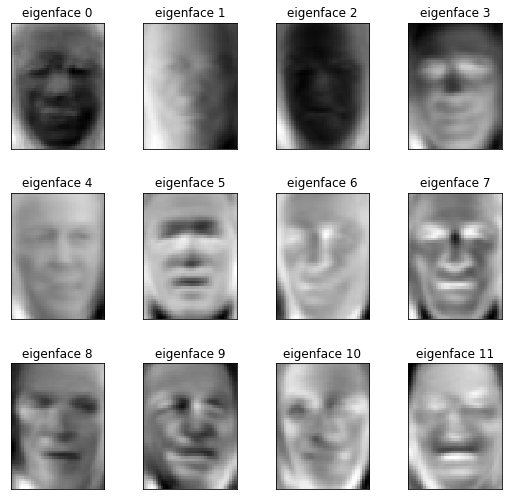

In [372]:
# reshape the pca components for visualization 
eigenfaces = pca.components_.reshape((n_components, h, w))

### display the eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_image(eigenfaces, eigenface_titles, h, w)

<a id='feature_engineering'></a>
## 6. FEATURE ENGINEERING

Type of feature engineering:
- Indicator variables
- Interaction features
- Feature representation
- External data
- Error analysis to explore more features

### 6.1. INDICATOR VARIABLES

- Created from thresholds:
    + Create an indicator variable `age >= 21` to distinguish consumers that could drink alcohol.
- Created from  multiple features: 
    + For predicting real-estate prices: an indicator variable for `house >= 2 beds and 2 baths` => good for rental
- Created from special events: 
    + Weekly sales for e-commerce site: an indicator variable for Black Friday and Christmas
- Created from groups of classes:
    + Example: Analyzing website conversions: and indicator for paid or free traffic source.

### 6.2. INTERACTION FEATURES

Some features can be combined to provide more information than they would as individuals.

- Sum of 2 features:
    + Combine `blue_pen_sale` and `black_pen_sale` to overall `pen_sale`.
- Difference between 2 features: 
    + Combine `house_built_date` and `house_purchase_date` to create `house_age`.
- Product of 2 features: 
    + Combine `price` and `conversion` to create `earnings`.
- Quotient of 2 features::
    + Devide `clicks` by `impressions` to create `click_through_rate` to compare across campaigns of different volume.

### 6.3. FEATURE REPRESENTATION

Try to represent data in a different way to gain more information.

- Date and time features:
    + Extract `purchase_datetime` to get `purchase_dayOfWeek`, `purchase_hourOfDay` or `purchases_over_last_30days`.
- Numeric to categorical mappings: 
    + Divide `years_in_school` into `elementary_school`, `middle_school` and `high_school`.
- Grouping sparse classes: 
    + Combine similar classes with low sample counts into a single `other1` class.
- Create dummy variables:
    + Transbform categorical features into dummy variables. Always do after grouping sparse classes.

### 6.4. EXTERNAL DATA

Bring in external data.

- Time series data:

- External API's: 
    + Create features using external API's, such as the Microsoft Computer Vision API can return the number of faces from an image.
- Geocoding: 
    + Change `address` into `latitude` and `longitude` => classify into `region` or `local demographics` (such as `median_income_within_2_miles`). 
    + [Useful extra dataset](https://www.precisely.com/data-guide).
- Other sources of the same data:
    + Example: Way to track a FB ad campaign? Combine FB tracking, Google Analytics, another 3rd-party software.

### 6.5. ERROR ANALYSIS

- Need to perform after training the first model => Analyze the misclassifier or high error data point => Think of next step for improvement: 
    + collecting more data
    + splitting the problem apart
    + engineering new feature to address errors
- Steps for error analysis
    + This is typically a manual process => Start with larger errors
    + Segment the data and compare the average error within each segments => Can create indicator variables for segments with the higher errors.
    + Run an unsupervised clustering algorithm on the misclassified data points => easier to spot the pattern => understand why/what makes the error.
    + Ask colleagues/domain experts.